# Visualising (and other things for) Word Embeddings

In this example, we'll train a deep learning model on word embeddings to see what information can be gleamed from it.

# Load and/or import the required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import xlsxwriter as xlw
import os
import html
import re
#import seaborn as sb
import tensorflow as tf
import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import joblib
#import json
#import gzip
import math
import random
#import pandas as pd
#import numpy as np
#import gzip
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["font.family"] = "Cambria" # this sets the font type to use for any matplotlib graphs

# Write some functions to use

In [2]:
# apply a text cleaning function to column reviewText
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # make lower case
    text = text.lower()
    # make words and numbers only
    text = re.sub('[^A-Za-z0-9 ]+','', text)
    
    
    return text.strip()


# Define a function for generating skipgrams
def skipgrams_generator(text, tokenizer, window_size, negative_samples):
    while True:
        sequences = tokenizer.texts_to_sequences(text)
        for sequence in sequences:
            target, context = skipgrams(sequence, vocabulary_size=len(tokenizer.word_index) + 1, window_size=window_size, negative_samples=negative_samples)
            x = [np.array([pair[0] for pair in target]), np.array([pair[1] for pair in target])]
            y = np.array(context)
            yield x, y
            


def get_similar(word):
    dists = np.dot(normalized_movies, normalized_movies[movie_to_idx[word]])
    closest = np.argsort(dists)[-2:]
    closest = closest[:][0]
    c = closest-1
    print(word_df_list[c], dists[c])
    

def similar_movies(movie):
    global dists
    global closest
    dists = np.dot(normalized_movies, normalized_movies[movie_to_idx[movie]])
    closest = np.argsort(dists)[-10:]
    furthest = np.argsort(dists)[::-1][-10:]
    #closest -= 1
    print("closest........")
    for c in reversed(closest):
        c=c-1
        print(c, word_df_list[c], dists[c], movie)
    print("furthest away........")   
    for c in reversed(furthest):
        c=c-1
        print(c, word_df_list[c], dists[c], movie)
        

def get_analogy(word1,word2,word3, top_n=5):
        vector1 = normalized_movies[movie_to_idx[word1]]
        vector2 = normalized_movies[movie_to_idx[word2]]
        vector3 = normalized_movies[movie_to_idx[word3]]

        # Perform the word analogy calculation
        analogy_vector = vector2 - vector1 + vector3

        # Calculate cosine similarities between the analogy vector and all other word vectors
        dists = np.dot(normalized_movies, analogy_vector)

        # Find the top N most similar words
        similar_words_indices = np.argsort(dists)[-top_n:]#[::-1]
        
        for c in reversed(similar_words_indices):
            c=c-1
            print(c, word_df_list[c], dists[c])
            

# make a word analogy graph (show where these words are)
# find word vectors
def get_analogy_graph(word1,word2,word3,top_n=5):
    global similar_words
    global similar_words_indices
    vector1 = normalized_movies[movie_to_idx[word1]]
    vector2 = normalized_movies[movie_to_idx[word2]]
    vector3 = normalized_movies[movie_to_idx[word3]]
    
    # Perform the word analogy calculation
    analogy_vector = vector2 - vector1 + vector3
    
    # Calculate cosine similarities between the analogy vector and all other word vectors
    dists = np.dot(normalized_movies, analogy_vector)
    
    # Find the top N most similar words
    similar_words_indices = np.argsort(dists)[-(top_n+2):]#[::-1]
    #similar_words_indices = similar_words_indices[1:]
    # Retrieve the actual words corresponding to the indices
    similar_words = [x for x, index in word_index.items() if index in similar_words_indices]
    
    # remove any words which are already covered
    similar_words = [x for x in similar_words if x not in [word1, word2, word3]]
    
    vectors = [word1, word2, word3] + similar_words
    word_indices = [word_index[word] for word in vectors]
    weights = movie_weights[word_indices]
    
    # tsne
    from sklearn.manifold import TSNE

    # The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
    # out some marginal improvements. NB: This takes almost an hour!
    tsne = TSNE(random_state=1, perplexity=1, n_iter=250, metric="cosine")
    
    embs = tsne.fit_transform(weights)
    
    df = pd.DataFrame()
    
    # Add to dataframe for convenience
    df['x'] = embs[:, 0]
    df['y'] = embs[:, 1]
    df['words'] = vectors
    
    # check to see if linked words or used words and colour accordingly
    wordser = [word1,word2,word3]
    df['chk'] = df['words'].apply(lambda x: "blue" if x in wordser else "red")
    
    def order(value):
        if value['words'] == wordser[0]:
            return "word1"
        elif value['words'] == wordser[1]:
            return "word2"
        elif value['words'] == wordser[2]:
            return "word3"
        else:
            return "other"
    
    df['order'] = df.apply(order,axis=1)
    
    df['index'] = df.index
    
    #df['words'] = df.apply(lambda row: row['words'] + " (" + str((row['index'])-2)+ ")" if row['order'] == "other" else row['words'], axis=1)
    df['words'] = df.apply(lambda row: row['words'] + " (" + str(len(df)-(row['index']))+ ")" if row['order'] == "other" else row['words'], axis=1)
    
    df_blues = df[df['order'] != "other"]
    
    df_reds = df[df['order'] == "other"]
    
    df_greens = pd.concat([df_blues[df_blues['order'] == 'word2'],df_blues[df_blues['order'] == 'word3']],axis=0)
    # and append word3
    df_reds = pd.concat([df_blues[df_blues['order'] == 'word3'],df_reds],axis=0)
    
    fig, ax = plt.subplots()
    #plt.figure(figsize=(8, 6))
    
    
    # connect lines based on order
    for i in range(0, len(df_blues), 2):
        ax.plot(df_blues.x[i:i+2], df_blues.y[i:i+2],color='blue')
        
    for i in range(0, len(df_greens), 1):
        ax.plot(df_greens.x[i:i+2], df_greens.y[i:i+2],color='green')
        
    for i in range(0, len(df_reds), 1):
        # want to plot word3 to each entry in df_reds
        df_reds1 = pd.concat([df_reds[0:1],df_reds[i:i+1]],axis=0)
        ax.plot(df_reds1.x, df_reds1.y,color='red')
        
    # plot points
    ax.scatter(df.x, df.y, color=df.chk, marker='o')
    
    for i, txt in zip(df.index, df.words):
        ax.annotate(txt, (df.x[i], df.y[i]))
    
    ax.set_title(word1+" is to "+word2+" as "+word3+" is to ?")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #set size of graph
    cmsize=1/2.54
    fig.set_size_inches(30*cmsize, 15*cmsize)
    
    #save plot
    #plt.savefig(output_folder+'figpath.png', dpi=400, bbox_inches='tight')
    

def bar_graph(x,y,xlabel,ylabel,title):
    fig, ax = plt.subplots()
    
    ax.barh(df_to_use[x],df_to_use[y])

    # Customise some display properties for line graph
    ax.set_ylabel(xlabel,size=8)
    ax.set_xlabel(ylabel,size=8)
    ax.set_title(title,size=9)
    #ax.set_xticklabels(df_to_use[x], rotation=90,size=8)
    #ax.legend(loc='upper left',fontsize=8)
    #ax.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1])
    ax.set_axisbelow(True) # to put gridlines at back
    ax.grid(linestyle='--',color='#CECECE')
    ax.tick_params(axis='y',labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
def six_bar_graph(x,y,xlabel,ylabel,title):
    
    fig, ax = plt.subplots(3,2,sharex=True,sharey=False,squeeze=True)
    
    # loop through each ax
    for i, ax in enumerate(ax.flat):
        color_to_use=np.random.rand(len(df_to_use[df_to_use['cluster']==i]),3)

        try:
            ax.barh(df_to_use[x][df_to_use['cluster']==i],df_to_use[y][df_to_use['cluster']==i], color=color_to_use[0])
            
            ax.set_title(df_to_use[x][df_to_use['cluster']==i].iloc[0]+" "+df_to_use[x][df_to_use['cluster']==i].iloc[1]+" "+df_to_use[x][df_to_use['cluster']==i].iloc[2],size=9)
            ax.set_axisbelow(True) # to put gridlines at back
            ax.grid(linestyle='--',color='#CECECE')
            ax.tick_params(axis='y',labelsize=8)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        except:
            pass
    
    plt.show()
    
    
# rank top 10 words for each cluster in cluster range
def clusters_rank_words_by_tfidf(word_list, cluster_range):
    global df_cluster_range1
    df_cluster_range1 = pd.DataFrame()
    for i in range(0,cluster_range):
        df_rev = df_clust[df_clust.Cluster == i]
        indices = df_rev.index
    
        summed_tfidf = df_clust1['magnitude'][df_clust1.index.isin(indices)]#[1::] # to match the index
        data = {'Word': [word_list[ii] for ii in range(0,len(indices))],#-1)], # to match the index
                'Summed TFIDF': summed_tfidf}
        #df_cluster_range.append(data)
        df_cluster_range = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
        df_cluster_range = df_cluster_range[:10] # top 10
        df_cluster_range['cluster'] = i
        df_cluster_range1 = pd.concat([df_cluster_range1,df_cluster_range])
    #df_cluster_range.to_frame()
    return df_cluster_range1
    #return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)

# Load the data and clean the data

In [3]:
data = pd.read_excel("C:\\Users\\kelvi\\Desktop\example_text.xlsx")
                     
# clean the text data
data['reviewText'] = data['reviewText'].apply(clean)       

# Tokenize the data

In [4]:
reviews = data['reviewText'].to_list()

# Initialize the tokenizer and fit it on the reviews
tokenizer = Tokenizer()#Tokenizer(num_words=20000)
tokenizer.fit_on_texts(reviews)


# save tokenizer
joblib.dump(tokenizer,"token.pkl")

# load tokenizer
tokenizer = joblib.load("token.pkl")

# get word index
word_index = tokenizer.word_index
t = [x for _,x in tokenizer.word_index.items()]

word_df = pd.DataFrame.from_dict(word_index, orient='index')
word_df['word'] = word_df.index
word_df = word_df.reset_index()
word_df = word_df[['word']]

# Define and compile the model

In [5]:
clear_session()

# Define hyperparameters
embedding_size = 128
skip_window = 5
num_sampled = 1

# Define input layers
input_target = Input(shape=(1,))
input_context = Input(shape=(1,))

# Create embedding layer
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_size, input_length=1, name="embedding")

# Get target and context vectors
target_vector = Flatten()(embedding(input_target))
context_vector = Flatten()(embedding(input_context))

# Calculate dot product and apply a dense layer
dot_product = Dot(axes=1)([target_vector, context_vector])
output = Dense(1, activation='sigmoid')(dot_product)

# Build the model
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

random.seed(5) # for reproducability

# Fit the model using the skipgrams generator
model.fit(skipgrams_generator(reviews, tokenizer, skip_window, num_sampled),
                    steps_per_epoch=2000, epochs=15, verbose=2)

# save model
model.save("my_model.hdf5")

# load model
from keras.models import load_model
model = load_model("my_model.hdf5")


Epoch 1/15
2000/2000 - 14s - loss: 0.7096 - 14s/epoch - 7ms/step
Epoch 2/15
2000/2000 - 13s - loss: 0.5511 - 13s/epoch - 7ms/step
Epoch 3/15
2000/2000 - 13s - loss: 0.4797 - 13s/epoch - 7ms/step
Epoch 4/15
2000/2000 - 13s - loss: 0.4542 - 13s/epoch - 7ms/step
Epoch 5/15
2000/2000 - 13s - loss: 0.4393 - 13s/epoch - 7ms/step
Epoch 6/15
2000/2000 - 13s - loss: 0.4325 - 13s/epoch - 7ms/step
Epoch 7/15
2000/2000 - 13s - loss: 0.4302 - 13s/epoch - 7ms/step
Epoch 8/15
2000/2000 - 13s - loss: 0.4268 - 13s/epoch - 7ms/step
Epoch 9/15
2000/2000 - 13s - loss: 0.4249 - 13s/epoch - 7ms/step
Epoch 10/15
2000/2000 - 13s - loss: 0.4221 - 13s/epoch - 7ms/step
Epoch 11/15
2000/2000 - 13s - loss: 0.4220 - 13s/epoch - 7ms/step
Epoch 12/15
2000/2000 - 13s - loss: 0.4210 - 13s/epoch - 7ms/step
Epoch 13/15
2000/2000 - 13s - loss: 0.4206 - 13s/epoch - 7ms/step
Epoch 14/15
2000/2000 - 13s - loss: 0.4166 - 13s/epoch - 7ms/step
Epoch 15/15
2000/2000 - 13s - loss: 0.4183 - 13s/epoch - 7ms/step


# Get the embedding layer

In [6]:
emb_layer = model.get_layer('embedding')
(w,) = emb_layer.get_weights()


#########################################################################
### find similar ####
movie = model.get_layer('embedding')
movie_weights = movie.get_weights()[0]
movie_lengths = np.linalg.norm(movie_weights, axis=1) # word embedding magnitude
normalized_movies = (movie_weights.T / movie_lengths).T

movie_to_idx = word_index#{movie[0]: idx for idx, movie in enumerate(word_df)}
word_df_list = word_df['word'].to_list()

#*#*#* adjustment needed..? #*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#* 
# can either remove row 0 from these or add row 0 to word_index and word_df_list
#word_index.insert(0,'no_word_here') # does not work on dict
#word_df_list.insert(0,'no_word_here')
#movie_to_idx.insert(0,'no_word_here')

movie_lengths = movie_lengths[1::]
normalized_movies = normalized_movies[1::]

# Find similar words

In [7]:
woder = ["king","man"]

for wod in woder:
    similar_movies(wod) # list the top 10 closest and top 10 furthest words from this word
    
print("---"*5)  
get_similar("king") # get the most similar word to this

closest........
5 king 0.39019027 king
47 throne 0.56971204 king
97 position 0.5656618 king
94 encountered -0.14104603 king
46 who 0.2753244 king
96 heir 0.5345747 king
95 rightful 0.5768161 king
98 ready 0.58382523 king
32 regal 0.09868631 king
33 he 0.45169672 king
furthest away........
252 not -0.16537422 king
255 rulers -0.15589106 king
256 also -0.22965688 king
279 bright -0.1065715 king
178 emphasized -0.1294675 king
251 beyond -0.03721328 king
254 been -0.1478192 king
244 monarchs -0.09244074 king
253 only -0.29883128 king
93 commanding 0.020029144 king
closest........
43 man -0.010483265 man
93 commanding 0.665543 man
92 like 0.6469943 man
44 respect 1.0 man
45 all 0.6589773 man
91 himself 0.26365602 man
25 subjects 0.31732953 man
18 with 0.033927195 man
23 isabella 0.1355285 man
183 status 0.17356259 man
furthest away........
239 passed -0.13952316 man
268 end -0.03325167 man
233 forge -0.17101452 man
240 thrived -0.21072778 man
279 bright -0.022922164 man
248 legacy -0.101553

Word analogy graph

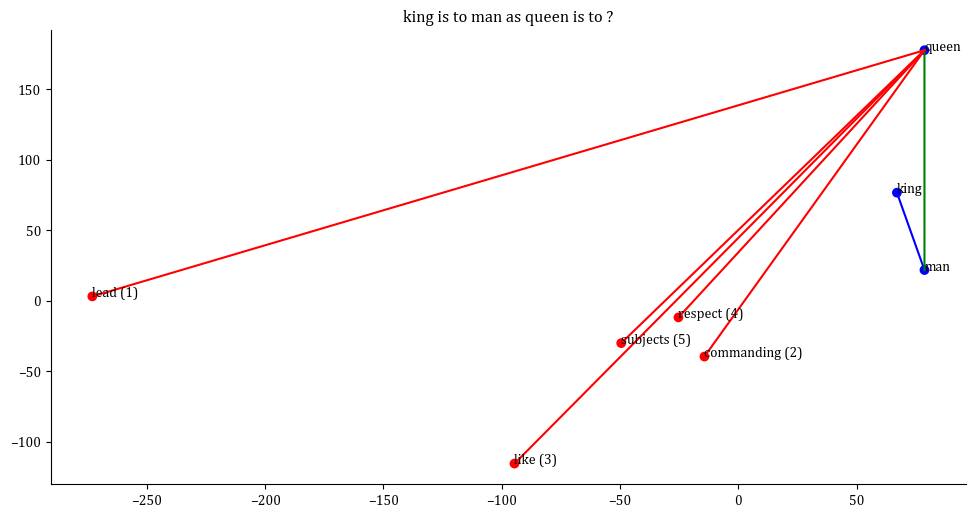

In [8]:
get_analogy_graph("king","man","queen") # make word analogy graph for these 3 words

# K-means clustering

In [9]:
cluster_number = 6

# cluster configuration
np.random.seed(0)
cluster_model = KMeans(n_clusters=cluster_number, n_init=10)
clusters = cluster_model.fit_predict(normalized_movies)

# get cluster centers
centroids = cluster_model.cluster_centers_

df_clust = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters})
df_clust1 = pd.merge(df_clust,word_df,how='left',left_on='Index', right_index=True)#[x for x, index in word_index.items() if index in word_df]
df_clust1['magnitude'] = movie_lengths

# get sum of cluster sizes
clust = df_clust.groupby(['Cluster']).count().reset_index()
print(clust)

# isolate first cluster
df_rev = df_clust[df_clust.Cluster == 0]
cluster_size = df_rev.shape[0]
print(f"{cluster_size} reviews cluster together with the reviews "
       "at index 0")

   Cluster  Index
0        0     54
1        1     46
2        2     38
3        3     50
4        4     42
5        5     51
54 reviews cluster together with the reviews at index 0


Graph clusters

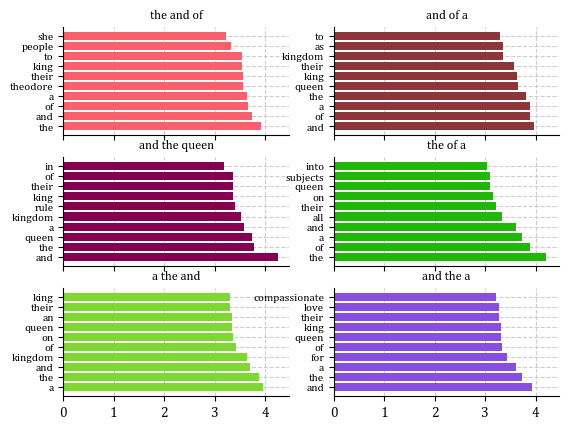

In [10]:
cluster_range = cluster_number

test = clusters_rank_words_by_tfidf(word_df_list,cluster_range)

# graph these
df_to_use = test # top 10
six_bar_graph('Word','Summed TFIDF','Word','Score','Word scores')

# How to find right number of clusters to use? - use minibatchkmeans

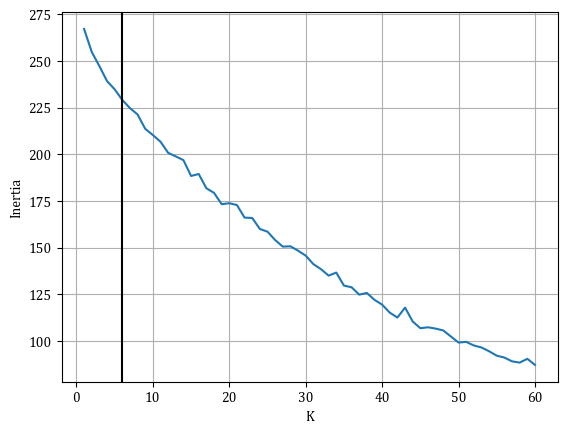

In [11]:
np.random.seed(0)
 
k_values = range(1, 61)
inertia_values = [MiniBatchKMeans(k, batch_size = 4096, n_init = 'auto').fit(normalized_movies).inertia_
                  for k in k_values]
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.axvline(cluster_number, c='k') # set to the number of clusters
plt.grid(True)
plt.show()

# Plot the clusters as tsne

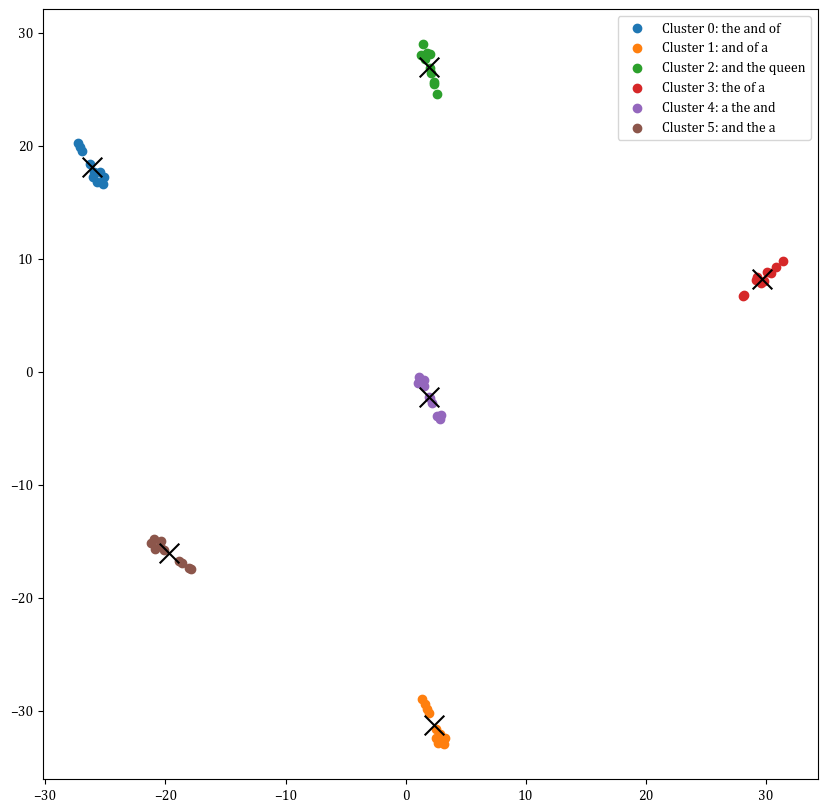

In [12]:
# perplixity numbers can result in odd looking graphs - the perplexity can vary from 1 to the number of entries
X_embedded = TSNE(n_components=2,random_state=42, perplexity=cluster_range).fit_transform(test[['Summed TFIDF', 'cluster']])
centers = np.array(cluster_model.cluster_centers_)
model = KMeans(n_clusters = cluster_range, init = "k-means++")
label = model.fit_predict(X_embedded)

#df_subset = pd.DataFrame()
#df_subset['tsne1'] = X_embedded[:,0]
#df_subset['tsne2'] = X_embedded[:,1]

# get cluster names
cluster_names = []
for i in range(0,cluster_range):
    clusterr = df_to_use['Word'][df_to_use['cluster']==i].iloc[0]+" "+df_to_use['Word'][df_to_use['cluster']==i].iloc[1]+" "+df_to_use['Word'][df_to_use['cluster']==i].iloc[2]
    cluster_names.append(clusterr)


plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(label)
for i in uniq:
   plt.scatter(X_embedded[label == i , 0] , X_embedded[label == i , 1] , label = "Cluster "+str(i) + ": " +cluster_names[i])
   plt.scatter(sum(X_embedded[label == i , 0])/len(X_embedded[label == i , 0]) , sum(X_embedded[label == i , 1])/len(X_embedded[label == i , 1]), marker="x", color='k',s=200)

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()

# Plot normalized_movies

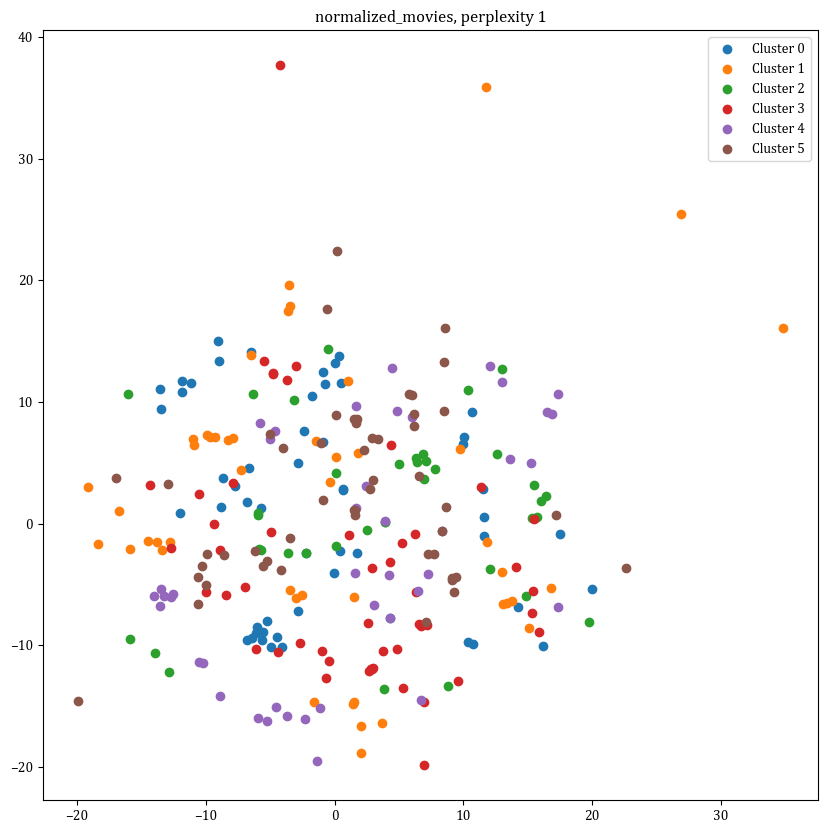

In [13]:
tsne = TSNE(random_state=1, perplexity=1, n_iter=250, metric="cosine")

embs = tsne.fit_transform(normalized_movies)

df = pd.DataFrame()

# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]
#df['words'] = word_df_list
df['clust'] = df_clust1['Cluster']

# graph this
plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(df.clust)
for i in uniq:
   plt.scatter(df.x[df.clust == i] , df.y[df.clust == i] , label = "Cluster "+str(i))
plt.title("normalized_movies, perplexity 1")   

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()

# Plot normalized_movies with the word for 10 datapoints of each cluster

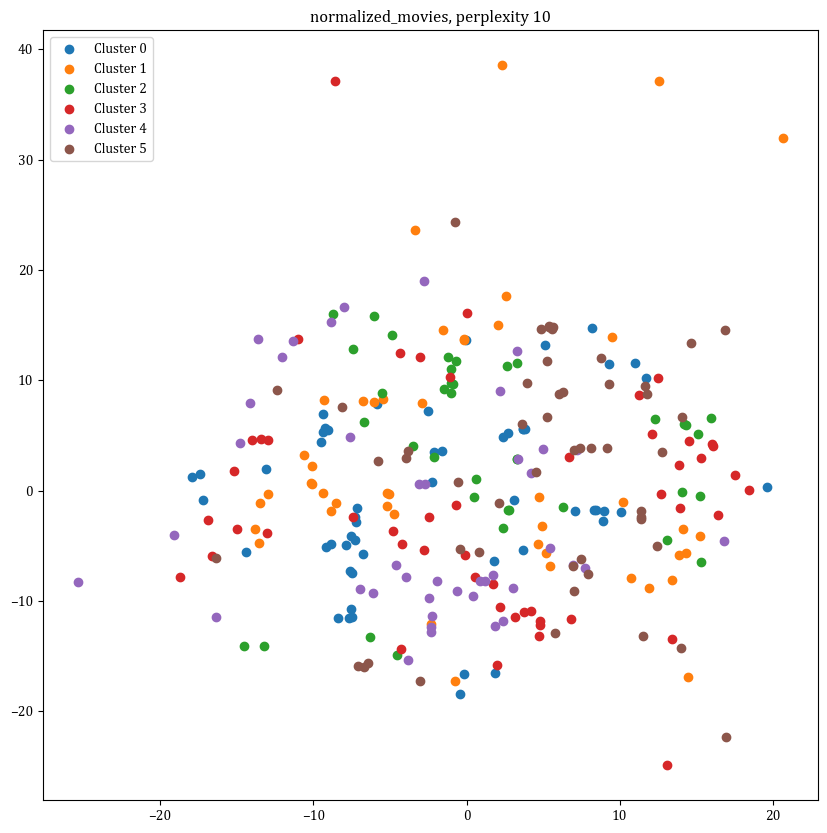

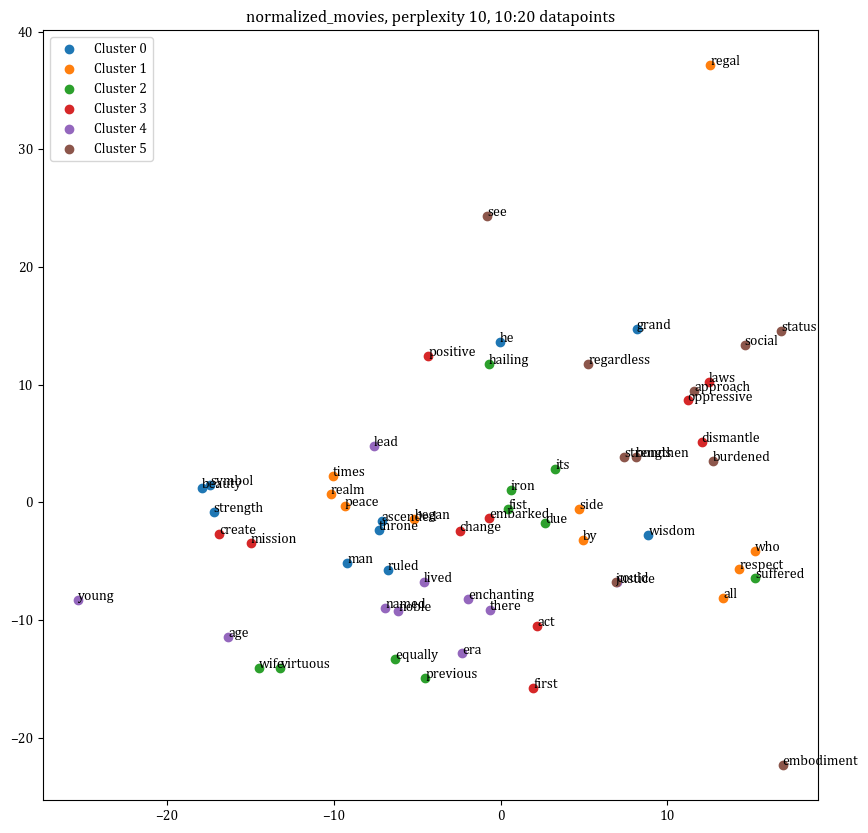

In [14]:
tsne = TSNE(random_state=10, perplexity=1, n_iter=250, metric="cosine")

embs = tsne.fit_transform(normalized_movies)

df = pd.DataFrame()

# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]
#df['words'] = word_df_list
df['clust'] = df_clust1['Cluster']

# graph this
plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(df.clust)
for i in uniq:
   plt.scatter(df.x[df.clust == i] , df.y[df.clust == i] , label = "Cluster "+str(i))
plt.title("normalized_movies, perplexity 10")   

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()

# graph this
plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(df.clust)
for i in uniq:
   plt.scatter(df.x[df.clust == i][10:20] , df.y[df.clust == i][10:20] , label = "Cluster "+str(i))
   for ii, txt in zip(df.index[df.clust == i][10:20], df_clust1.word[df_clust1.Cluster==i][10:20]):
       plt.annotate(txt, (df.x[ii], df.y[ii]))
plt.title("normalized_movies, perplexity 10, 10:20 datapoints")  

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()

# Alternatively you can view the word by the cluster grouping (localising words in each cluster)

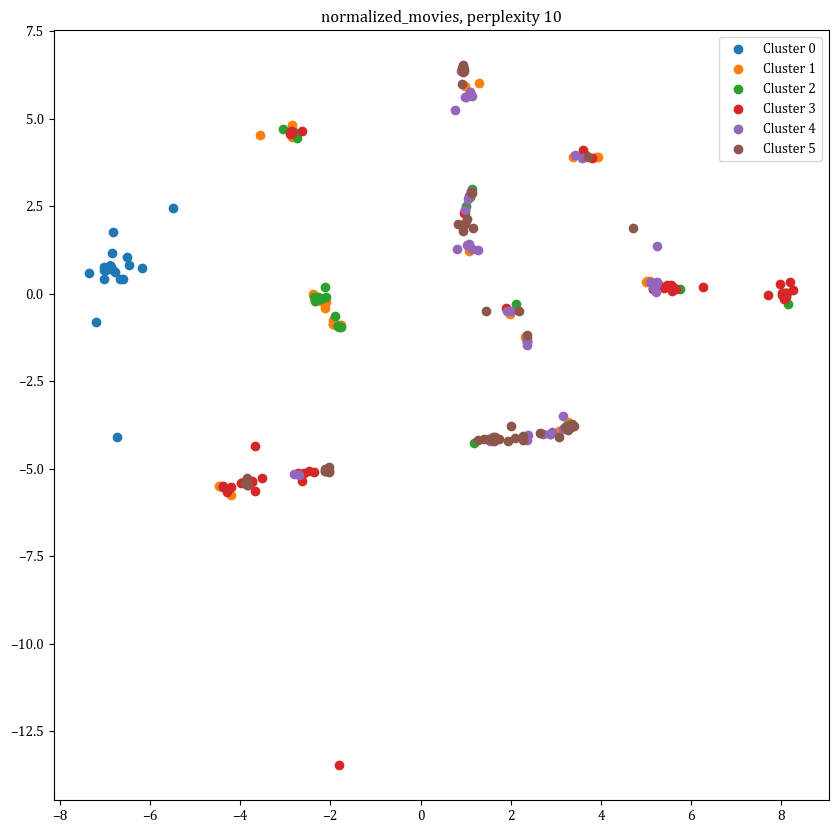

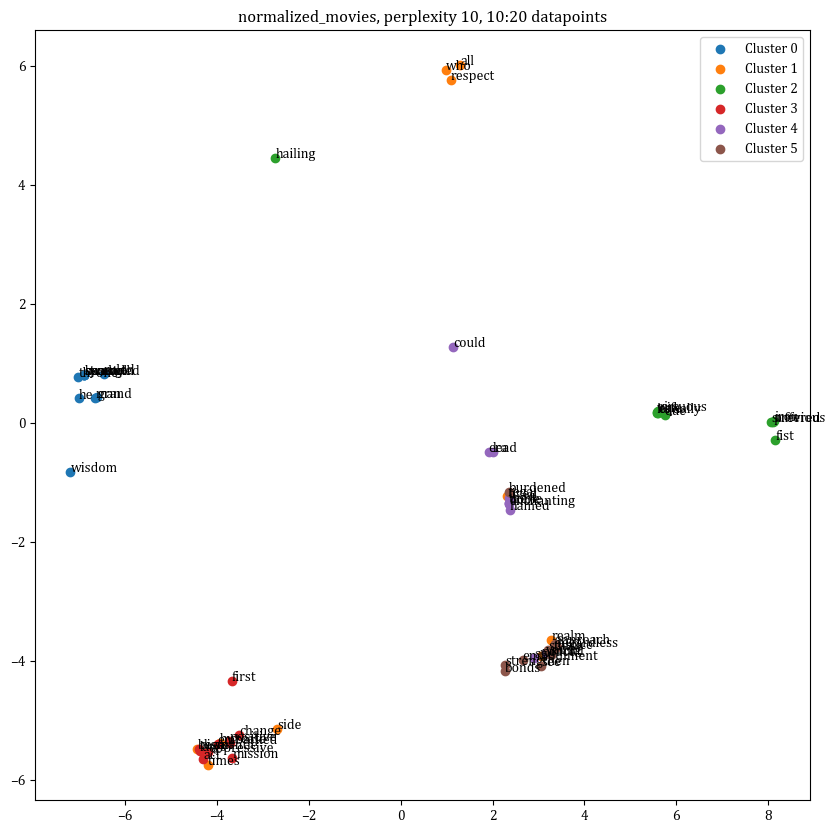

In [15]:
tsne = TSNE(random_state=10, perplexity=5, n_iter=250, metric="cosine")

embs = tsne.fit_transform(df_clust1[['Index','Cluster']])

df = pd.DataFrame()

# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]
#df['words'] = word_df_list
df['clust'] = df_clust1['Cluster']

# graph this
plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(df.clust)
for i in uniq:
   plt.scatter(df.x[df.clust == i] , df.y[df.clust == i] , label = "Cluster "+str(i))
plt.title("normalized_movies, perplexity 10")   

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()

# graph this
plt.figure(figsize=(10,10))
#plt.scatter(df_subset['tsne1'] , df_subset['tsne2'])
#plt.show()
uniq = np.unique(df.clust)
for i in uniq:
   plt.scatter(df.x[df.clust == i][10:20] , df.y[df.clust == i][10:20] , label = "Cluster "+str(i))
   for ii, txt in zip(df.index[df.clust == i][10:20], df_clust1.word[df_clust1.Cluster==i][10:20]):
       plt.annotate(txt, (df.x[ii], df.y[ii]))
plt.title("normalized_movies, perplexity 10, 10:20 datapoints")  

#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()#plt.show()